In [1]:
# Package imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import plot_confusion_matrix, f1_score, accuracy_score

In [2]:
def read_data():
    df = pd.DataFrame()
    dirs = os.listdir('data')
    for folder in dirs:
        if folder != '.DS_Store':
            filenames = glob.glob(os.path.join('data', folder, '*/*.txt'), recursive = True)
            for filename in filenames:
                if ('MANIFEST.txt' not in filename) and ('annotations.txt' not in filename):
                    temp_df = pd.read_csv(filename, '\t')
                    row_dict = {'cancer': folder}
                    for index, row in temp_df.iterrows():
                        row_dict[row['miRNA_ID']] = row['reads_per_million_miRNA_mapped']

                    df = df.append(row_dict, ignore_index = True)
    
    le = preprocessing.LabelEncoder()
    df['cancer_code'] = le.fit_transform(df['cancer'])
    
    df.to_csv('data_cleaned.csv', index=False)


In [3]:
def load_data():
    return pd.read_csv('data_cleaned.csv')

In [4]:
def random_forest(X_train, y_train):
    #no depth limit - trees will grow as deep as possible until purity/all features are exhausted
    #no min split - default is 2
    #bootstrap default is True
    #max features does feature bagging
    params = {'n_estimators': [100, 200, 300, 400, 500], 'max_features': ('sqrt', 'log2')} 
    print('Grid Search on Random Forest...')
    rf = RandomForestClassifier()
    clf = GridSearchCV(rf, params)
    clf.fit(X_train, y_train)
    
    results_df = pd.DataFrame(clf.cv_results_)
    results_df.to_csv('rf_cv_results.csv')
    
    results_df.head()
    
    print('Best Random Forest Params (score %f):' % clf.best_score_)
    print(clf.best_params_)
    print()
    
    return clf.best_estimator_

In [5]:
'''
Performs 5-fold CV over a range of hyperparameters and returns the best-performing SVM model
'''
def svm(X_train, y_train):
    params = {'kernel':('linear', 'poly', 'rbf'), 'C':[10, 1, 0.1, 0.01], 'degree': [2,3], 'gamma': [1, 0.1, 0.01, 0.001], 'cache_size': [1000]}
    print('Grid Search on SVM...')
    svc = SVC()
    clf = GridSearchCV(svc, params)
    clf.fit(X_train, y_train)
    
    results_df = pd.DataFrame(clf.cv_results_)
    results_df.to_csv('svm_cv_results.csv')
    
    print('Best SVM Params (score %f):' % clf.best_score_)
    print(clf.best_params_)
    print()
    
    return clf.best_estimator_

In [6]:
'''
Calculates accuracy, f1 score, and a confusion matrix for the given model and (scaled) evaluation data.
Params:
    model: the model to be evaluated
    X_eval: feature-scaled evaluation set
    y_eval: evaluation labels
    name: string of the model name (used for graph titles)
'''
def calc_stats(model, X_eval, y_eval, name):
    print('Evaluation of %s Model:' % name)
    #results
    preds = model.predict(X_eval)
    f_score = f1_score(y_eval, preds, average='micro')
    acc_score = accuracy_score(y_eval, preds)
    print('%s: F1 = %f, accuracy = %f' % (name, f_score, acc_score))
    
    #confusion matrix
    plot_confusion_matrix(model, X_eval, y_eval)
    plt.title('Confusion Matrix for {} Model'.format(name))
    plt.savefig('imgs/{}_confusion.png'.format(name))
    plt.show()
    
    print()

In [7]:
df = load_data()
df.head()

,cancer,hsa-let-7a-1,hsa-let-7a-2,hsa-let-7a-3,hsa-let-7b,hsa-let-7c,hsa-let-7d,hsa-let-7e,hsa-let-7f-1,hsa-let-7f-2,...,hsa-mir-942,hsa-mir-943,hsa-mir-944,hsa-mir-95,hsa-mir-9500,hsa-mir-96,hsa-mir-98,hsa-mir-99a,hsa-mir-99b,cancer_code
0,Breast Invasive Carcinoma,17225.641202,17168.697999,17165.904559,37132.340301,4217.020216,410.420821,1099.541016,4846.188888,4989.513855,...,1.933920,0.0,3.867840,5.586880,0.0,31.157602,47.703362,1462.043595,37550.067043,0
1,Breast Invasive Carcinoma,9675.101346,9620.924588,9710.866472,11593.826262,1817.884192,334.477994,1189.031704,4199.545275,4264.938315,...,5.925583,0.0,1.269768,1.058140,0.0,26.136053,44.547686,668.744359,13635.189582,0
2,Breast Invasive Carcinoma,9947.288063,10160.137808,10204.137755,9738.288314,1366.198361,243.649708,813.999023,735.899117,752.399097,...,0.549999,0.0,0.000000,3.849995,0.0,26.399968,24.199971,228.249726,33884.359339,0
3,Breast Invasive Carcinoma,18022.771624,18041.827151,18067.323984,17540.076324,3884.643741,230.679238,2396.299685,8376.112098,8537.815694,...,3.891622,0.0,1.476132,2.549683,0.0,26.033608,49.785921,1360.323117,17850.466713,0
4,Breast Invasive Carcinoma,4686.419964,4688.795641,4698.100379,2814.682994,323.884043,234.697147,1773.938243,4904.982301,5131.364576,...,0.296960,0.0,0.098987,0.296960,0.0,123.535234,43.554089,89.978788,28231.760414,0


In [8]:
len(df)

2895

In [9]:
def main():
    df = load_data()
    #split into train, test, and evaluation sets
    X = df.drop(columns=['cancer', 'cancer_code'])
    y = df['cancer_code']
    X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.2, random_state=2, stratify=y)
    #X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25, random_state=2, stratify=y_train)
    
    #scale data
    min_max_scalar = preprocessing.MinMaxScaler()
    X_train_scaled = min_max_scalar.fit_transform(X_train)
    #min_max_scalar = preprocessing.MinMaxScaler()
    #X_test_scaled = min_max_scalar.fit_transform(X_test)
    #min_max_scalar = preprocessing.MinMaxScaler()
    X_eval_scaled = min_max_scalar.transform(X_eval)
    
    svm_model = svm(X_train_scaled, y_train)
    
    calc_stats(svm_model, X_eval_scaled, y_eval, 'SVM')
    
    rf_model = random_forest(X_train_scaled, y_train)
    calc_stats(rf_model, X_eval_scaled, y_eval, 'RF')

Grid Search on SVM...
Best SVM Params (score 0.960703):
{'C': 0.1, 'cache_size': 1000, 'degree': 2, 'gamma': 1, 'kernel': 'linear'}

Evaluation of SVM Model:
SVM: F1 = 0.972366, accuracy = 0.972366


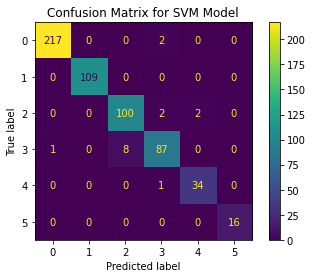


Grid Search on Random Forest...
Best Random Forest Params (score 0.970206):
{'max_features': 'sqrt', 'n_estimators': 300}

Evaluation of RF Model:
RF: F1 = 0.975820, accuracy = 0.975820


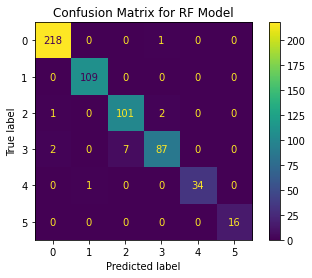

In [10]:
main()

In [2]:
def numTrees(file):
    df = pd.read_csv(file)
    new_df = df[df['param_max_features'] == 'sqrt']
    plt.xlabel('Number of Trees')
    plt.ylabel('Validation Accuracy')
    plt.plot(new_df['param_n_estimators'], new_df['mean_test_score'], '-o')
    plt.savefig('imgs/numTrees', bbox_inches='tight')
    plt.show()

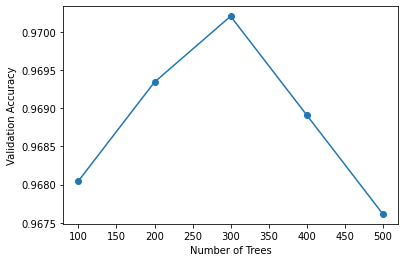

In [3]:
numTrees('rf_cv_results.csv')